In [1]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using Statistics
include("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/self_couple/concentrated_new/lattice_BZ.jl")
include("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/self_couple/bc_sign_flip/rmg_spinors.jl")
include("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/self_couple/bc_sign_flip/dirac_spinors.jl")
include("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/self_couple/bc_sign_flip/patch_methods.jl")
include("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/self_couple/concentrated_new/concentrated_BC.jl")

state_coefficients (generic function with 1 method)

In [2]:
# general parameters
pd = 50
kappa = 1
w = sqrt(3) * kappa
spacing = 0.5 * (w / 2 / pd)

0.008660254037844387

In [3]:
# RMG parameters
a = 4*pi/(3*kappa)
uD = 10
t0 = 3
t1 = 5
t2 = -0.21
t3 = 0
t4 = 0
Nl = 3
index = 1

1

In [4]:
# 3-patch parameters
delta = -1
vF = 0

0

<font size="12">BC Decoupling</font>

In [5]:
alpha_list = (10) * [exp(pi/3 * im), exp(pi/4 * im), exp(pi/2 * im)]
# alpha_list = exp(im * pi/2) * [0, 10^6, 10^8, 10^10]

3-element Vector{ComplexF64}:
     5.000000000000001 + 8.660254037844386im
    7.0710678118654755 + 7.071067811865475im
 6.123233995736766e-16 + 10.0im

In [6]:
function rmg_decoupled_comp(pd, w, spacing, a, uD, t0, t1, t2, t3, t4, Nl, index, kappa, vF, delta, alpha_list)
    # get an mBZ centered at the kappa-point
    grid_sor = make_hex([kappa, 0], w / 2, w / 2 / pd)

    grid_patch = make_hex([0, 0], w / 2, w / 2 / pd)

    fig = Figure(size=(2400, 800 * length(alpha_list)), fontsize=25)

    for j in 1:length(alpha_list)
        alpha = alpha_list[j]
        sor_bc = rmg_spinor_bc(grid_sor, spacing, a, uD, t0, t1, t2, t3, t4, Nl, index) .+ 
        bc_no_spinors(grid_patch, spacing, vF, kappa, delta, alpha)[1]

        patch_bc = rmg_patch_bc(grid_patch, spacing, a, uD, t0, t1, t2, t3, t4, Nl, index, kappa, vF, delta, alpha)

        # pure_spinor_bc = rmg_spinor_bc(grid_sor, spacing, a, uD, t0, t1, t2, t3, t4, Nl, index)

        mass = uD * (index + 1 - (1/2) * (Nl - 1))

        pure_spinor_bc = dirac_patch_bc(grid_patch, spacing, (3/2) * a * t0, -mass, index, kappa, vF, delta, alpha)

        ax1 = Axis(fig[j, 1], title = string(round(angle(alpha) / pi, sigdigits=3)), 
        xlabel = L"k_x", ylabel = L"k_y")
        tricontourf!(ax1, grid_patch[:, 1], grid_patch[:, 2], patch_bc, colormap = :Spectral)
        X, ax1, tr1 = tricontourf(grid_patch[:, 1], grid_patch[:, 2], patch_bc, colormap = :Spectral)
        cb1 = Colorbar(fig[j, 2], tr1)

        ax3 = Axis(fig[j, 3], title = string(round(angle(alpha) / pi, sigdigits=3))
        , xlabel = L"k_x", ylabel = L"k_y")
        tricontourf!(ax3, grid_patch[:, 1], grid_patch[:, 2], sor_bc, colormap = :Spectral)
        X, ax3, tr3 = tricontourf(grid_patch[:, 1], grid_patch[:, 2], sor_bc, colormap = :Spectral)
        cb3 = Colorbar(fig[j, 4], tr3)

        ax5 = Axis(fig[j, 5], title = string(round(angle(alpha) / pi, sigdigits=3))
        , xlabel = L"k_x", ylabel = L"k_y")
        tricontourf!(ax5, grid_patch[:, 1], grid_patch[:, 2], pure_spinor_bc, colormap = :Spectral)
        X, ax5, tr3 = tricontourf(grid_patch[:, 1], grid_patch[:, 2], pure_spinor_bc, colormap = :Spectral)
        cb3 = Colorbar(fig[j, 6], tr3)
    end
    ax_c1 = Axis(fig[:, 1], title = L"\text{RMG 3P } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(ax_c1, label = false)
    hidespines!(ax_c1)

    ax_c2 = Axis(fig[:, 3], title = L"\text{RMG Decoupled } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(ax_c2, label = false)
    hidespines!(ax_c2)

    ax_c3 = Axis(fig[:, 5], title = L"\text{Dirac 3P } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(ax_c3, label = false)
    hidespines!(ax_c3)

    fig
end

rmg_decoupled_comp (generic function with 1 method)

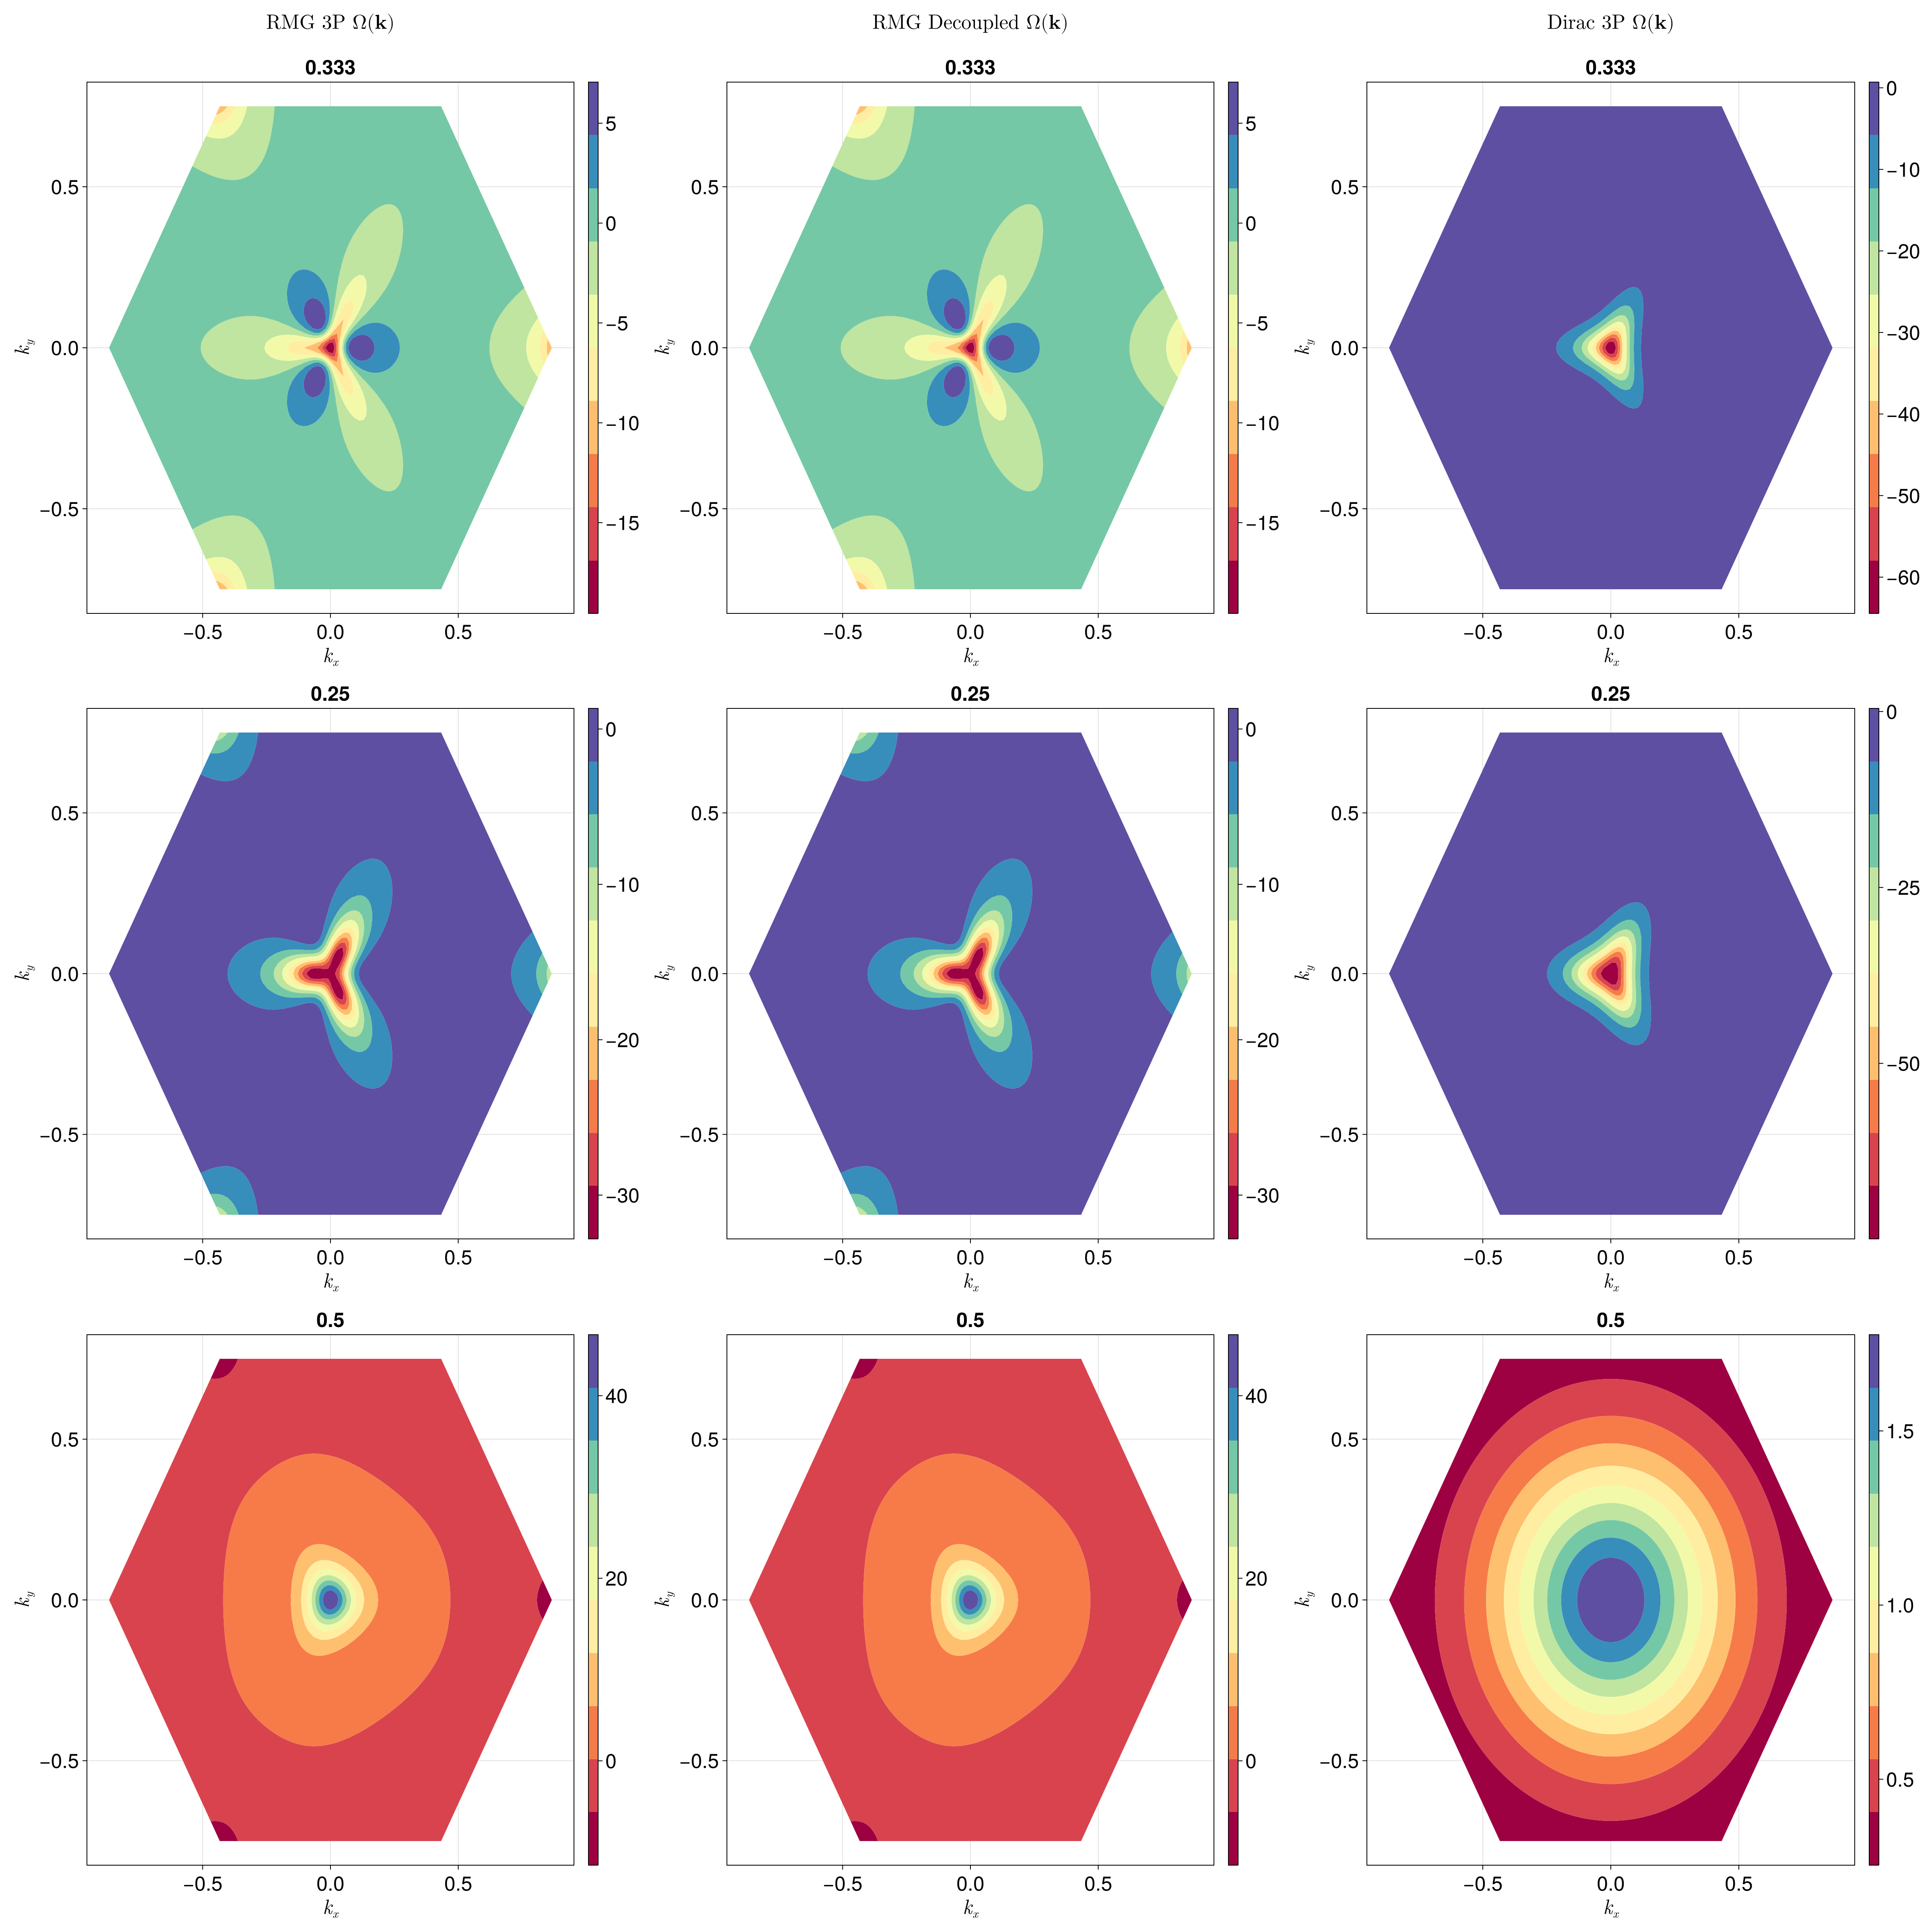

In [7]:
rmg_decoupled_comp(pd, w, spacing, a, uD, t0, t1, t2, t3, t4, Nl, index, kappa, vF, delta, alpha_list)

<font size="12">Decoupling mid-patch</font>

In [8]:
function rmg_decouple_theta_bc(a, uD, t0, t1, t2, t3, t4, Nl, l, kappa, vF, delta, alpha_list, w, p, pd)
    theta_list = range(0, 2*pi, 1000)
    curvature_ns_1 = Array{Float64}(undef, length(theta_list))
    curvature_ns_2 = Array{Float64}(undef, length(theta_list))
    curvature_ns_4 = Array{Float64}(undef, length(theta_list))
    curvature_ns_5 = Array{Float64}(undef, length(theta_list))
    curvature_ns_3 = Array{Float64}(undef, length(theta_list))
    spacing = 10^(-4) * (w / 2 / pd)
    # create plot
    P = Figure(size=(3000, 2000), fontsize=30)
    for j in 1:length(alpha_list)
        alpha = alpha_list[j]
        for i in 1:length(theta_list)
            theta = theta_list[i]
            x = p * cos(theta)
            y = p * sin(theta)
            grid = reshape([x, y], (1, 2))
            spinor_grid = reshape([kappa + x, y], (1, 2))
            curvature_ns_1[i] = rmg_patch_bc(grid, spacing, a, uD, t0, t1, t2, t3, t4, Nl, l, kappa, vF, delta, alpha)[1]
            curvature_ns_2[i] = rmg_spinor_bc(spinor_grid, spacing, a, uD, t0, t1, t2, t3, t4, Nl, l)[1] .+ 
            bc_no_spinors(grid, spacing, vF, kappa, delta, alpha)[1][1]
            curvature_ns_4[i] = rmg_spinor_bc(spinor_grid, spacing, a, uD, t0, t1, t2, t3, t4, Nl, l)[1]
            curvature_ns_5[i] = bc_no_spinors(grid, spacing, vF, kappa, delta, alpha)[1][1]
            curvature_ns_3[i] = abs(curvature_ns_1[i] - curvature_ns_2[i])
        end
        ax1 = Axis(P[j, 1], title = string(angle(alpha) / pi), xlabel = L"\theta", ylabel = L"\Omega")
        lines!(ax1, theta_list, curvature_ns_1)
        ax2 = Axis(P[j, 2], title = string(angle(alpha) / pi), xlabel = L"\theta", ylabel = L"\Omega")
        lines!(ax2, theta_list, curvature_ns_2)
        ax2 = Axis(P[j, 3], title = string(angle(alpha) / pi), xlabel = L"\theta", ylabel = L"\Omega")
        lines!(ax2, theta_list, curvature_ns_3)
        ax2 = Axis(P[j, 4], title = string(angle(alpha) / pi), xlabel = L"\theta", ylabel = L"\Omega")
        lines!(ax2, theta_list, curvature_ns_4)
        ax2 = Axis(P[j, 5], title = string(angle(alpha) / pi), xlabel = L"\theta", ylabel = L"\Omega")
        lines!(ax2, theta_list, curvature_ns_5)
    end
    
    axs1 = Axis(P[:, 1], title = L"\text{RMG 3P } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(axs1, label = false)
    hidespines!(axs1)

    axs2 = Axis(P[:, 2], title = L"\text{RMG Decoupled } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(axs2, label = false)
    hidespines!(axs2)

    axs3 = Axis(P[:, 3], title = L"\text{Difference } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(axs3, label = false)
    hidespines!(axs3)

    axs4 = Axis(P[:, 4], title = L"\text{Parent } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(axs4, label = false)
    hidespines!(axs4)

    axs5 = Axis(P[:, 5], title = L"\text{Pure 3P } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(axs5, label = false)
    hidespines!(axs5)
    P
end

rmg_decouple_theta_bc (generic function with 1 method)

In [9]:
# parameters
# alpha_list = exp(im * pi/2) * [0, 10, 10^6, 10^8, 10^12]
alpha_list = (5) * [exp(pi/3 * im), exp(pi/4 * im), exp(pi/2 * im)]
p = w / 2

0.8660254037844386

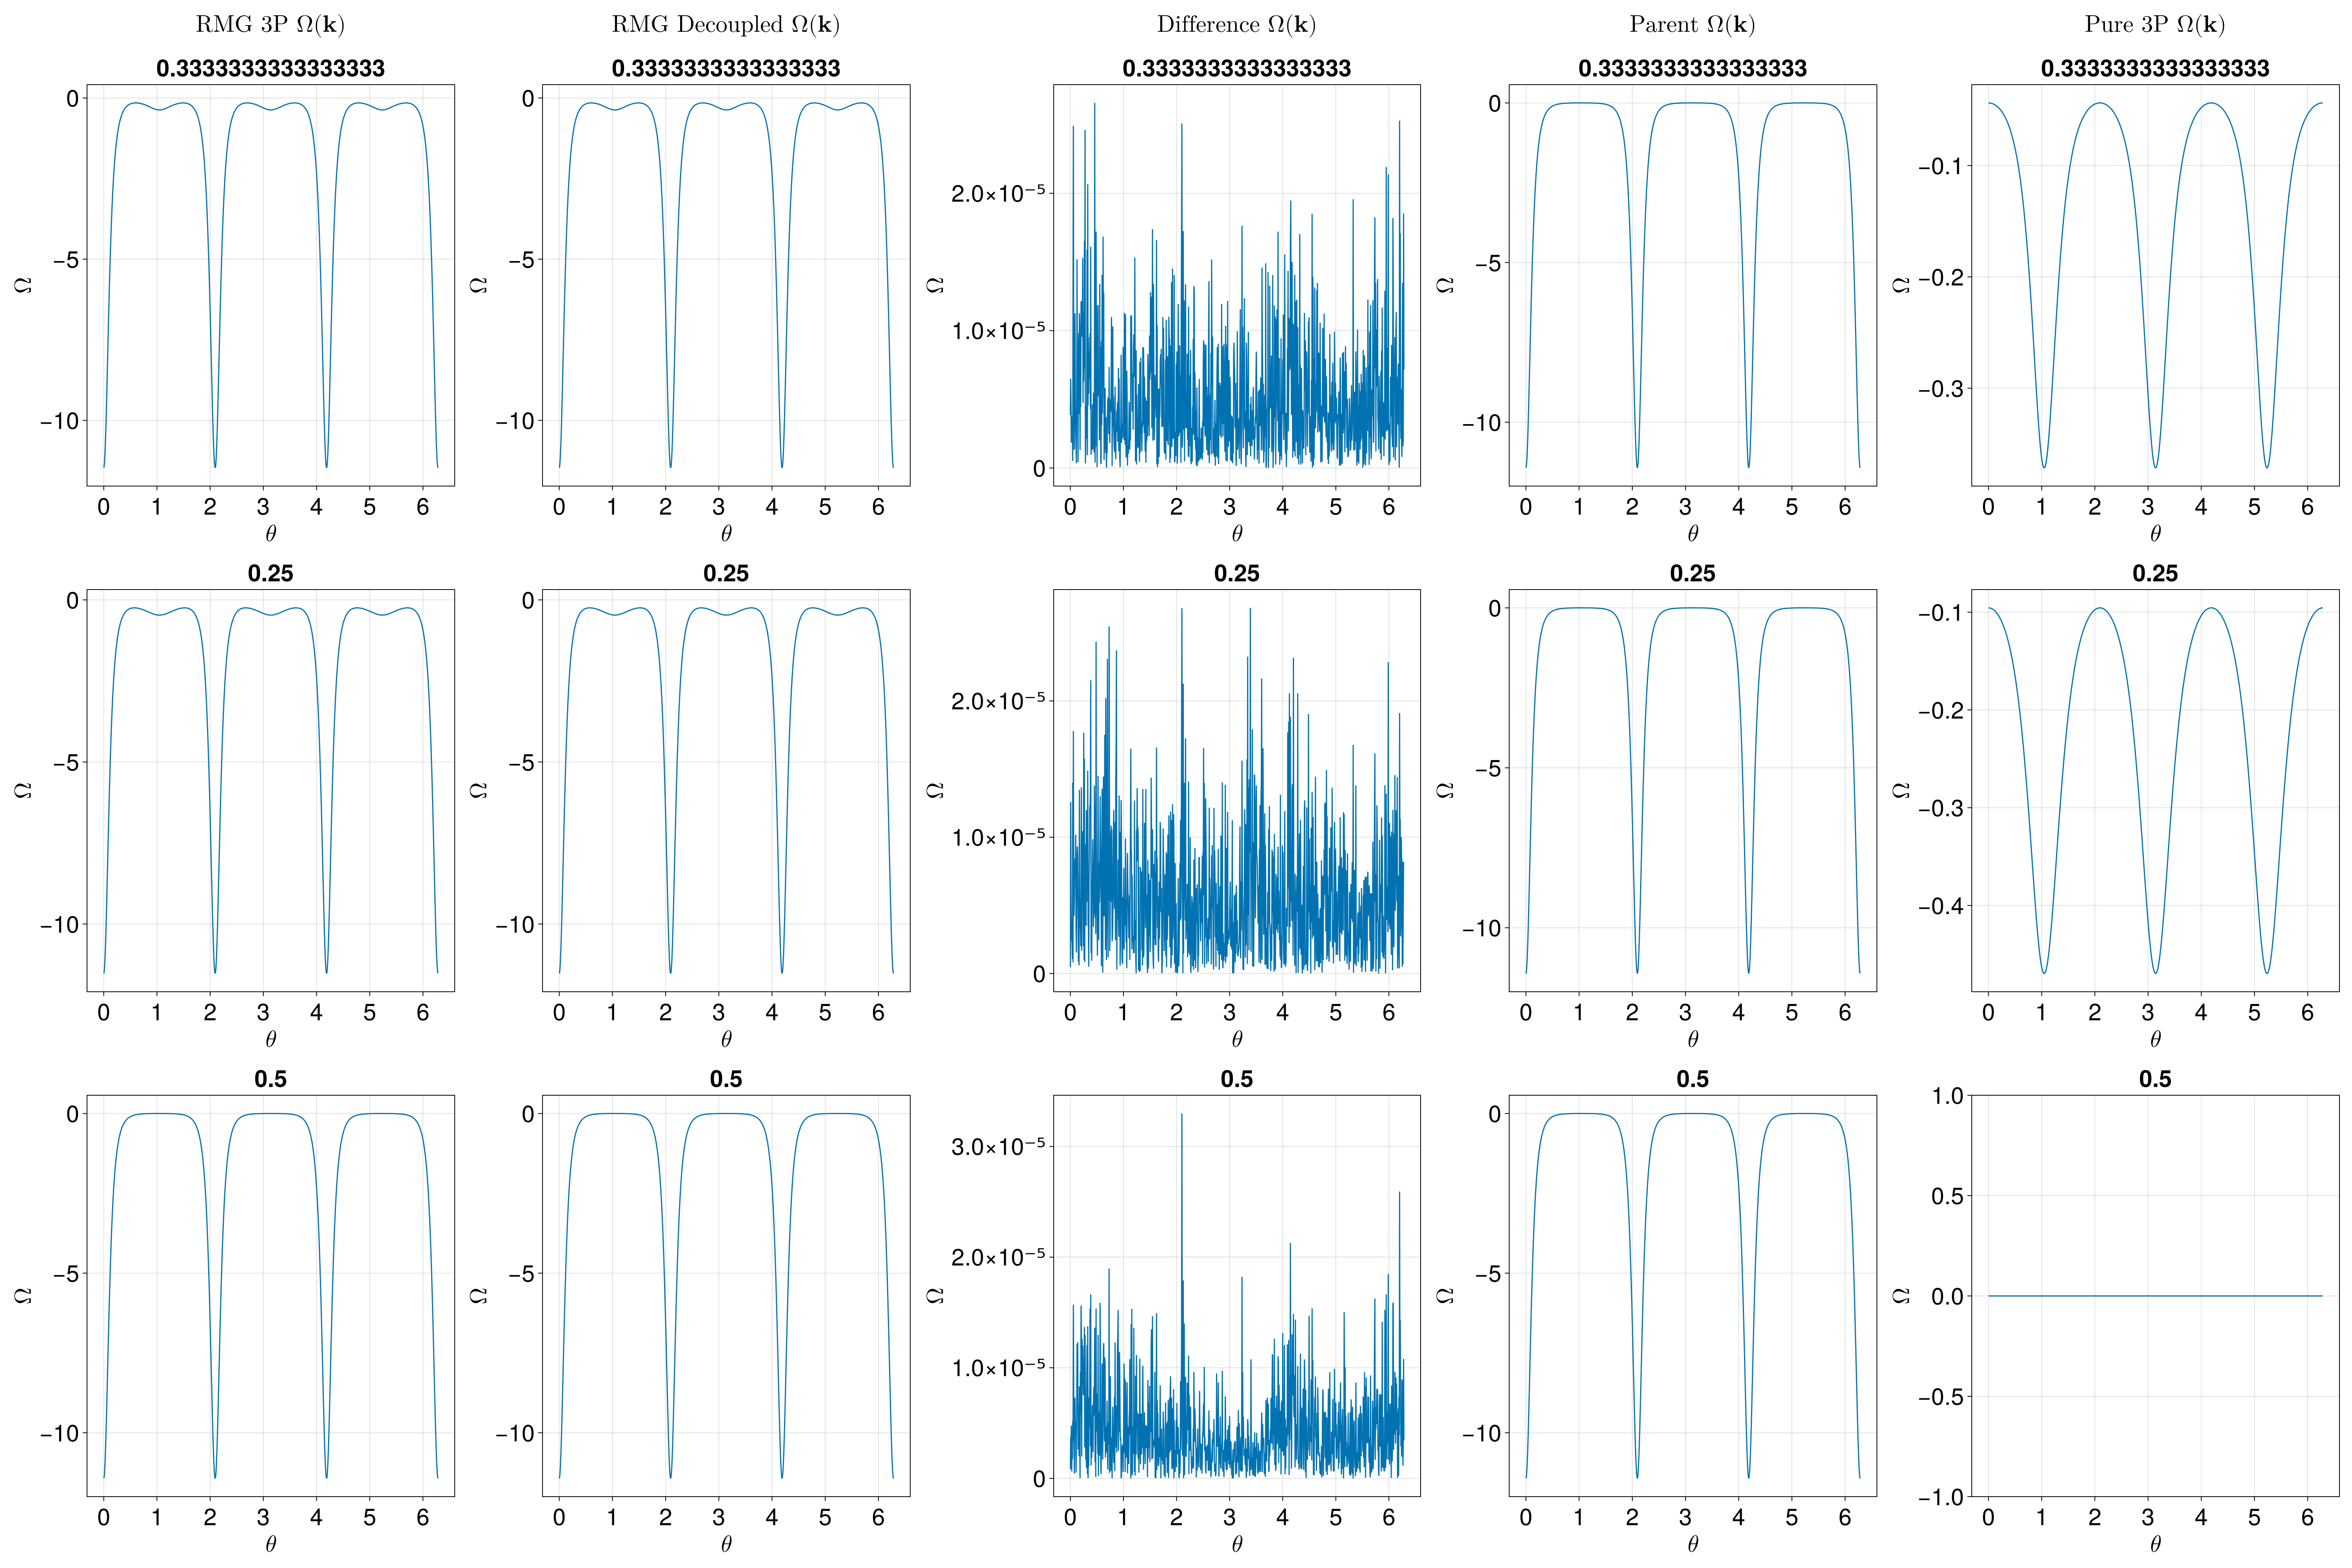

In [10]:
rmg_decouple_theta_bc(a, uD, t0, t1, t2, t3, t4, Nl, 1, kappa, vF, delta, alpha_list, w, p, pd)

In [11]:
function bc_spacing(a, uD, t0, t1, t2, t3, t4, Nl, l, kappa, vF, delta, alpha_list, w, p, pd)
    spacing_list = range(10^(1), 10^(4), 10^3)

    curvature_1 = Array{Float64}(undef, length(spacing_list))
    curvature_2 = Array{Float64}(undef, length(spacing_list))
    curvature_3 = Array{Float64}(undef, length(spacing_list))

    P = Figure(size=(3000, 2000), fontsize=30)

    for j in 1:length(alpha_list)
        alpha = alpha_list[j]
        for i in 1:length(spacing_list)
            spacing = (w / 2 / pd) / spacing_list[i]

            x = p * cos(10*pi/7)
            y = p * sin(10*pi/7)
            grid = reshape([x, y], (1, 2))

            curvature_1[i] = rmg_patch_bc(grid, spacing, a, uD, t0, t1, t2, t3, t4, Nl, l, kappa, vF, delta, alpha)[1]
            curvature_2[i] = rmg_spinor_bc(grid, spacing, a, uD, t0, t1, t2, t3, t4, Nl, l)[1]
            curvature_3[i] = bc_no_spinors(grid, spacing, vF, kappa, delta, alpha)[1][1]
        end
        ax1 = Axis(P[j, 1], title = string(angle(alpha) / pi), xlabel = L"\frac{1}{spacing}", ylabel = L"\Omega")
        lines!(ax1, spacing_list, curvature_1)
        ax2 = Axis(P[j, 2], title = string(angle(alpha) / pi), xlabel = L"\frac{1}{spacing}", ylabel = L"\Omega")
        lines!(ax2, spacing_list, curvature_2)
        ax2 = Axis(P[j, 3], title = string(angle(alpha) / pi), xlabel = L"\frac{1}{spacing}", ylabel = L"\Omega")
        lines!(ax2, spacing_list, curvature_3)
    end
    axs1 = Axis(P[:, 1], title = L"\text{RMG 3P } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(axs1, label = false)
    hidespines!(axs1)

    axs2 = Axis(P[:, 2], title = L"\text{Parent } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(axs2, label = false)
    hidespines!(axs2)

    axs3 = Axis(P[:, 3], title = L"\text{Pure 3P } \Omega (\textbf{k})", titlegap = 60)
    hidedecorations!(axs3, label = false)
    hidespines!(axs3)
    
    P
end

bc_spacing (generic function with 1 method)

In [12]:
# parameters
# alpha_list = exp(im * pi/2) * [0, 10, 10^6, 10^8, 10^12]
alpha_list = (5) * [exp(pi/3 * im), exp(pi/4 * im), exp(pi/2 * im)]
p = w / 2

0.8660254037844386

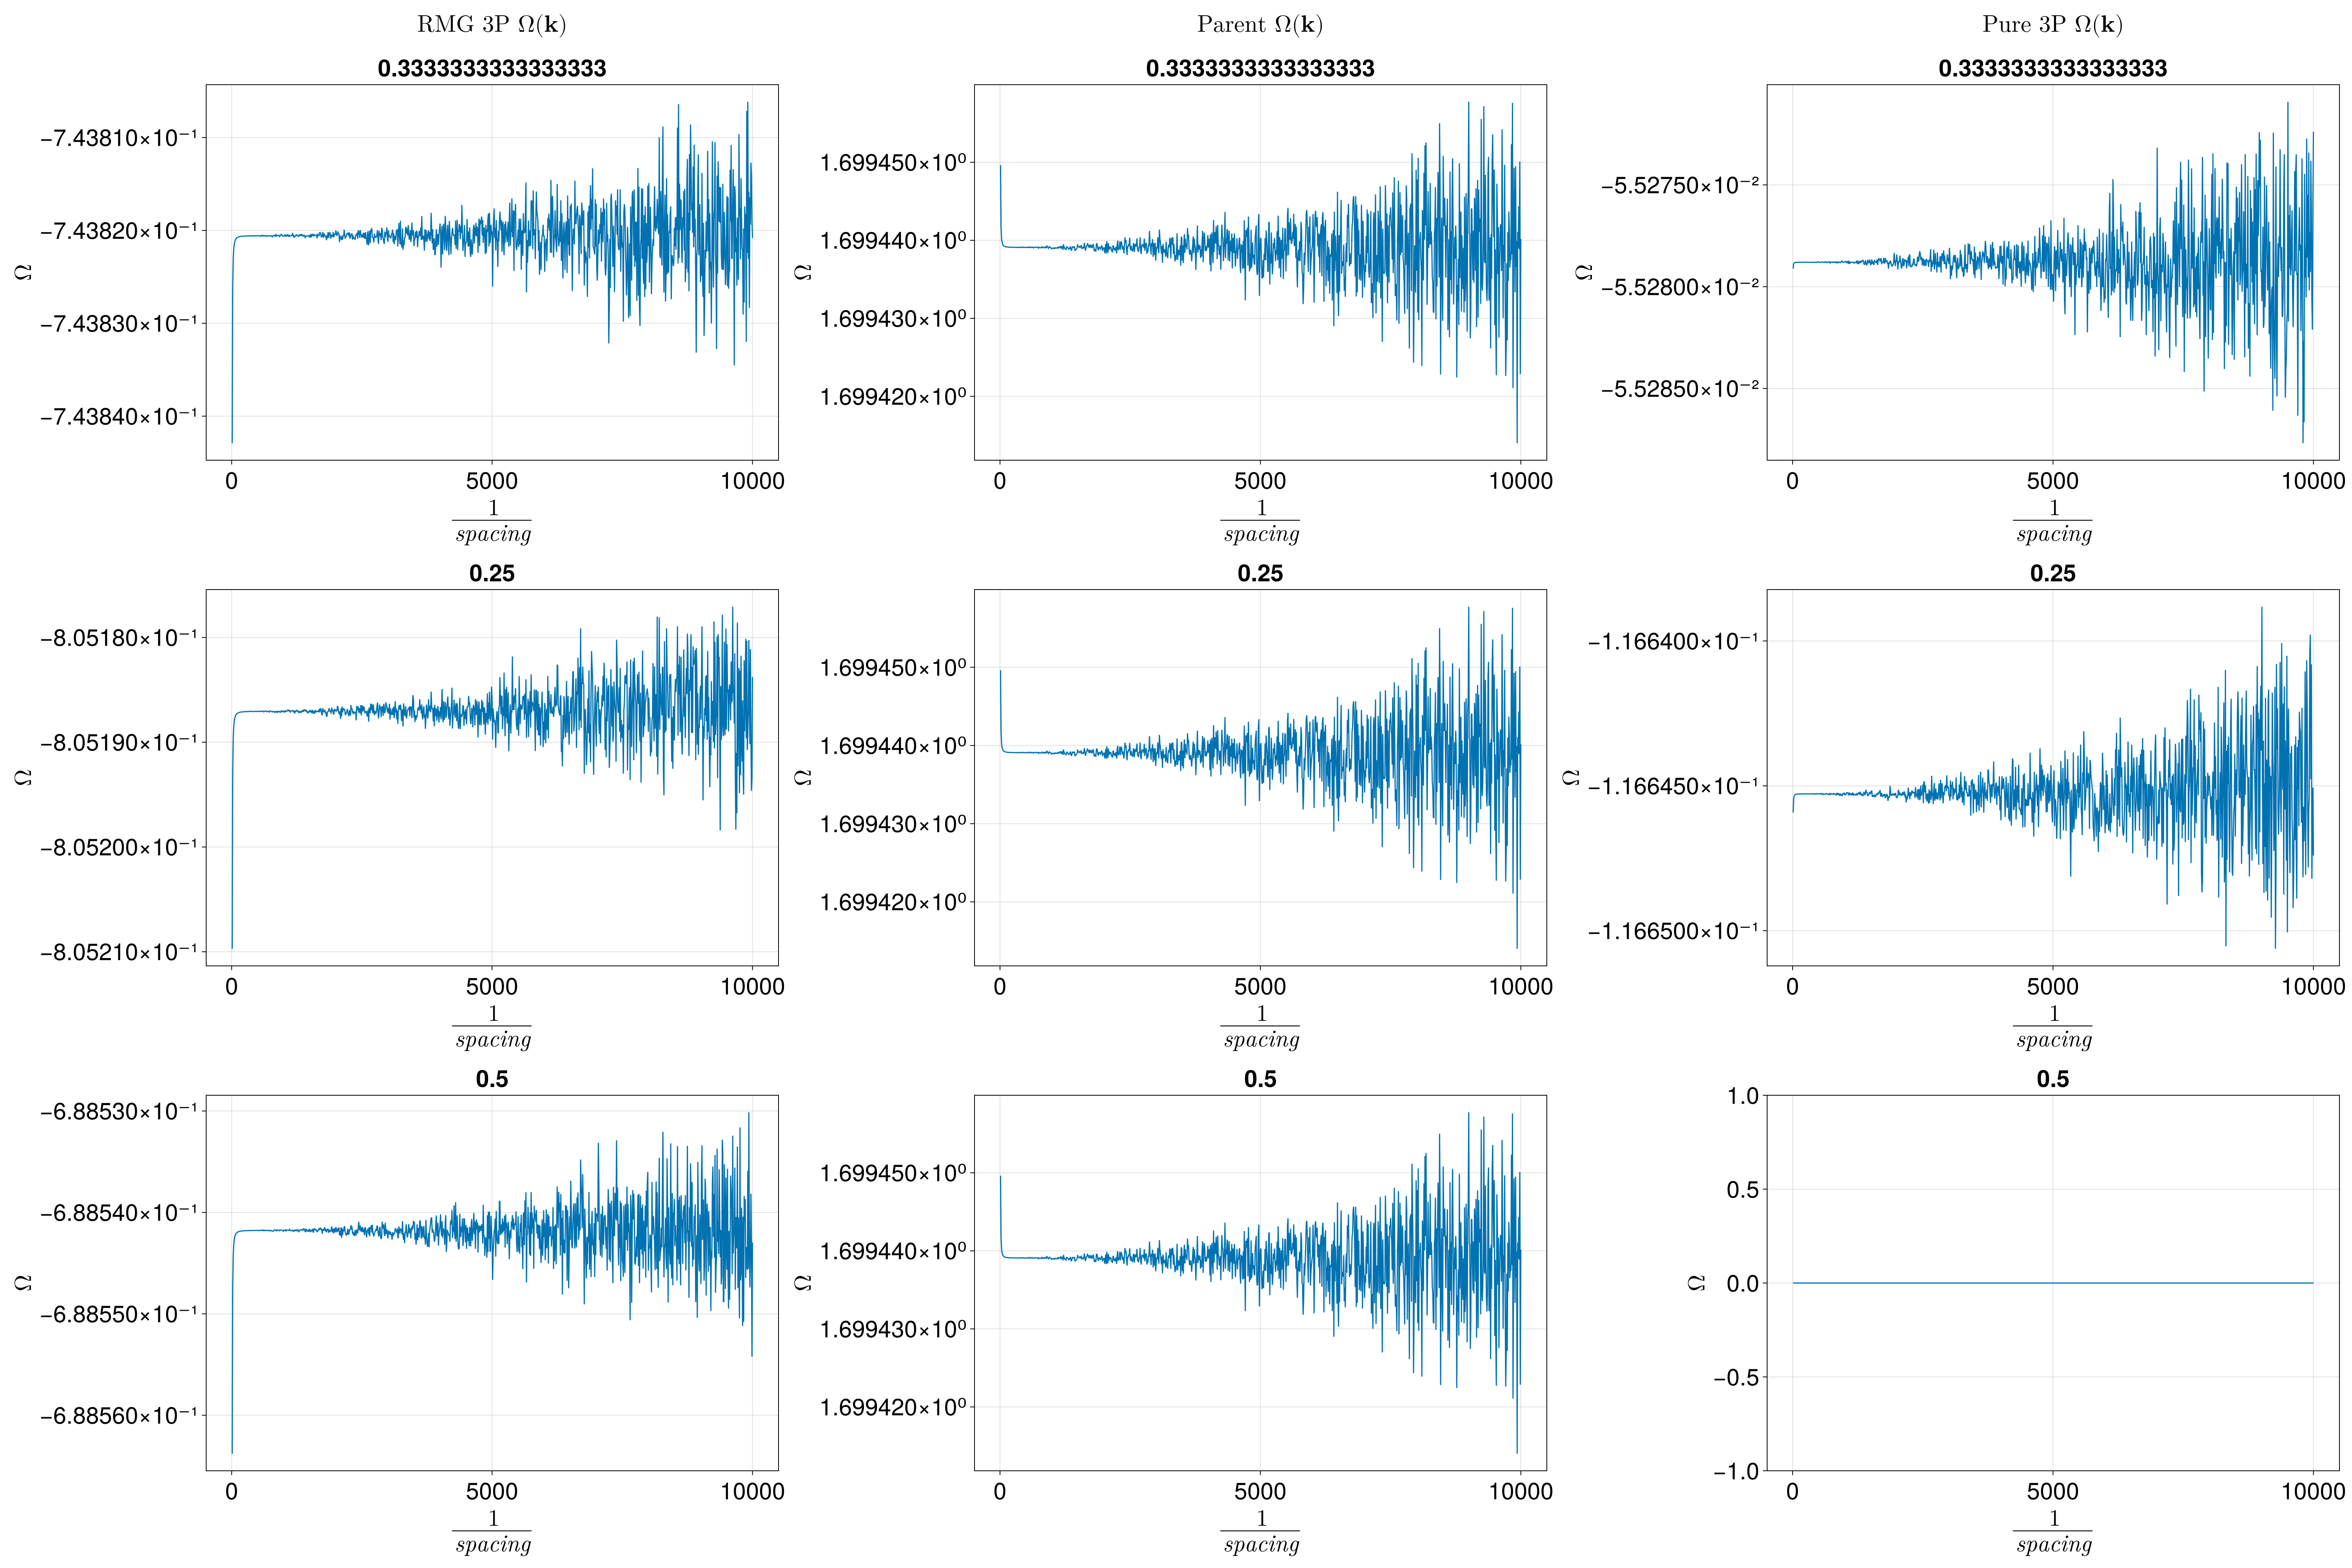

In [13]:
bc_spacing(a, uD, t0, t1, t2, t3, t4, Nl, index, kappa, vF, delta, alpha_list, w, p, pd)